In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Set Plotly theme for bright visuals
import plotly.io as pio
pio.templates.default = "plotly"

In [203]:
# Load datasets
matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')

In [204]:
matches.shape

(1095, 20)

In [205]:
matches.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [206]:
deliveries.shape

(260920, 17)

In [207]:
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [208]:
matches.columns

Index(['id', 'season', 'city', 'date', 'match_type', 'player_of_match',
       'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'result', 'result_margin', 'target_runs', 'target_overs', 'super_over',
       'method', 'umpire1', 'umpire2'],
      dtype='object')

In [209]:
deliveries.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

## Data Cleaning & Feature Engineering

In [210]:
# null values
matches.isnull().sum()

,0
id,0
season,0
city,51
date,0
match_type,0
player_of_match,5
venue,0
team1,0
team2,0
toss_winner,0


In [211]:
# Display unique values in the 'method' column
matches['method'].unique()

# Fill missing values in the 'method' column with 'No method applied'
matches['method'].fillna('No method applied')

,method
0,No method applied
1,No method applied
2,No method applied
3,No method applied
4,No method applied
...,...
1090,No method applied
1091,No method applied
1092,No method applied
1093,No method applied


In [212]:
# Check the most frequent city in the dataset
matches.value_counts('city')

,count
city,
Mumbai,173
Kolkata,93
Delhi,90
Chennai,85
Hyderabad,77
Bangalore,65
Chandigarh,61
Jaipur,57
Pune,51


In [213]:
# Fill missing city values with 'Mumbai' (mode of the 'city' column)
matches['city'].fillna('Mumbai')

,city
0,Bangalore
1,Chandigarh
2,Delhi
3,Mumbai
4,Kolkata
...,...
1090,Hyderabad
1091,Ahmedabad
1092,Ahmedabad
1093,Chennai


In [214]:
# Fill missing values in 'winner' column safely
matches.loc[:, 'winner'] = matches['winner'].fillna('No Result')

# Fill missing values in 'player_of_match' column safely
matches.loc[:, 'player_of_match'] = matches['player_of_match'].fillna('No Result')

In [215]:
# Calculate the median of 'result_margin' and fill missing values with it
# Some matches might have extremely high or low margins, making the mean unreliable.
# The median provides a central, stable value unaffected by outliers.

median_margin = matches['result_margin'].median()
matches['result_margin'].fillna(median_margin)

,result_margin
0,140.0
1,33.0
2,9.0
3,5.0
4,5.0
...,...
1090,4.0
1091,8.0
1092,4.0
1093,36.0


In [216]:
# Calculate the median of 'target_runs' and fill missing values with it
# Some matches may have exceptionally high target runs due to high-scoring games.
# The median smooths out these variations, ensuring a more reasonable imputation.

median_target_runs = matches['target_runs'].median()
matches['target_runs'].fillna(median_target_runs)

,target_runs
0,223.0
1,241.0
2,130.0
3,166.0
4,111.0
...,...
1090,215.0
1091,160.0
1092,173.0
1093,176.0


In [217]:
# Calculate the median of 'target_overs' and fill missing values with it
# Some games may have very few or full 20 overs, leading to a skewed distribution.
# The median helps maintain a realistic and consistent imputation.

median_target_overs = matches['target_overs'].median()
matches['target_overs'].fillna(median_target_overs)

,target_overs
0,20.0
1,20.0
2,20.0
3,20.0
4,20.0
...,...
1090,20.0
1091,20.0
1092,20.0
1093,20.0


In [218]:
matches.isnull().sum()

,0
id,0
season,0
city,51
date,0
match_type,0
player_of_match,0
venue,0
team1,0
team2,0
toss_winner,0


In [219]:
matches['venue'].unique()

array(['M Chinnaswamy Stadium',
       'Punjab Cricket Association Stadium, Mohali', 'Feroz Shah Kotla',
       'Wankhede Stadium', 'Eden Gardens', 'Sawai Mansingh Stadium',
       'Rajiv Gandhi International Stadium, Uppal',
       'MA Chidambaram Stadium, Chepauk', 'Dr DY Patil Sports Academy',
       'Newlands', "St George's Park", 'Kingsmead', 'SuperSport Park',
       'Buffalo Park', 'New Wanderers Stadium', 'De Beers Diamond Oval',
       'OUTsurance Oval', 'Brabourne Stadium',
       'Sardar Patel Stadium, Motera', 'Barabati Stadium',
       'Brabourne Stadium, Mumbai',
       'Vidarbha Cricket Association Stadium, Jamtha',
       'Himachal Pradesh Cricket Association Stadium', 'Nehru Stadium',
       'Holkar Cricket Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Subrata Roy Sahara Stadium',
       'Maharashtra Cricket Association Stadium',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex', 'Sh

In [220]:
# Sample mapping dictionary to standardize venue names.
venue_mapping = {
    "Arun Jaitley Stadium, Delhi": "Arun Jaitley Stadium",
    "Eden Gardens, Kolkata": "Eden Gardens",
    "M Chinnaswamy Stadium, Bengaluru": "M Chinnaswamy Stadium",
    "M.Chinnaswamy Stadium": "M Chinnaswamy Stadium",
    "Dr DY Patil Sports Academy, Mumbai": "Dr DY Patil Sports Academy",
    "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam": "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium",
    "MA Chidambaram Stadium, Chepauk, Chennai": "MA Chidambaram Stadium",
    "Punjab Cricket Association IS Bindra Stadium, Mohali": "Punjab Cricket Association IS Bindra Stadium",
    "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh": "Punjab Cricket Association IS Bindra Stadium",
    "Rajiv Gandhi International Stadium, Uppal, Hyderabad": "Rajiv Gandhi International Stadium, Uppal",
    "Wankhede Stadium, Mumbai": "Wankhede Stadium",
    "Vidarbha Cricket Association Stadium, Jamtha": "Vidarbha Cricket Association Stadium, Jammu",
    "Vidarbha Cricket Association Stadium, Jammu, Delhi": "Vidarbha Cricket Association Stadium, Jammu",
    "MA Chidambaram Stadium, Chepauk": "MA Chidambaram Stadium",
    "Punjab Cricket Association IS Bindra Stadium" : "Punjab Cricket Association Stadium",
    "Himachal Pradesh Cricket Association Stadium, Dharamsala" : "Himachal Pradesh Cricket Association Stadium",
    "Maharashtra Cricket Association Stadium, Pune" : "Maharashtra Cricket Association Stadium",
    "Maharashtra Cricket Association Stadium, Pune, Maharashtra" : "Maharashtra Cricket Association Stadium",
    "Maharashtra Cricket Association Stadium, Pune, India" : "Maharashtra Cricket Association Stadium",
    "Rajiv Gandhi International Stadium, Uppal" : "Rajiv Gandhi International Stadium",
    "Sawai Mansingh Stadium, Jaipur" : "Sawai Mansingh Stadium",
    "Sawai Mansingh Stadium, Jaipur, Rajasthan" : "Sawai Mansingh Stadium",
    "Sawai Mansingh Stadium, Jaipur, India" : "Sawai Mansingh Stadium",
}
matches['venue'] = matches['venue'].replace(venue_mapping)

In [221]:
matches['venue'].unique()

array(['M Chinnaswamy Stadium',
       'Punjab Cricket Association Stadium, Mohali', 'Feroz Shah Kotla',
       'Wankhede Stadium', 'Eden Gardens', 'Sawai Mansingh Stadium',
       'Rajiv Gandhi International Stadium', 'MA Chidambaram Stadium',
       'Dr DY Patil Sports Academy', 'Newlands', "St George's Park",
       'Kingsmead', 'SuperSport Park', 'Buffalo Park',
       'New Wanderers Stadium', 'De Beers Diamond Oval',
       'OUTsurance Oval', 'Brabourne Stadium',
       'Sardar Patel Stadium, Motera', 'Barabati Stadium',
       'Brabourne Stadium, Mumbai',
       'Vidarbha Cricket Association Stadium, Jammu',
       'Himachal Pradesh Cricket Association Stadium', 'Nehru Stadium',
       'Holkar Cricket Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Subrata Roy Sahara Stadium',
       'Maharashtra Cricket Association Stadium',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex', 'Sheikh Zayed Stadiu

In [222]:
#Top 5 Stadiums with the Most Matches
# Count matches per venue and reset index
stadium_data = matches.value_counts('venue').reset_index()
stadium_data.columns = ['Stadium', 'Number of Matches']

# Select Top 10 stadiums
top_5_stadiums = stadium_data.head(5)

# Visualization
top_5_stadiums.style.background_gradient(cmap='cividis')


,Stadium,Number of Matches
0,Wankhede Stadium,118
1,M Chinnaswamy Stadium,94
2,Eden Gardens,93
3,MA Chidambaram Stadium,85
4,Rajiv Gandhi International Stadium,64


In [223]:
# Top 5 Teams with the Most Wins
# Count matches won by each team
winning_data = matches.value_counts('winner').reset_index(name='Number of Matches Won')

# Select Top 10 teams
top_5_winners = winning_data.head(5)

# Visualization
top_5_winners.style.background_gradient(cmap='cividis')


,winner,Number of Matches Won
0,Mumbai Indians,144
1,Chennai Super Kings,138
2,Kolkata Knight Riders,131
3,Royal Challengers Bangalore,116
4,Rajasthan Royals,112


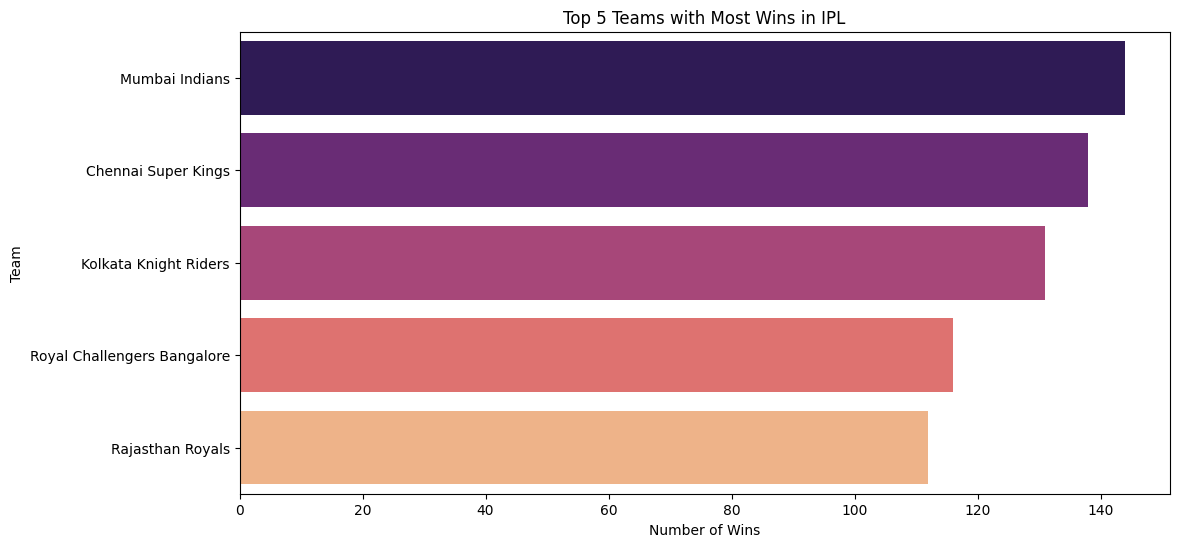

In [224]:
# Win Distribution using a Bar Plot

# Plot bar chart for top 10 winning teams
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Number of Matches Won',
    y='winner',
    data=top_5_winners,
    hue='winner',
    dodge=False,
    palette='magma',
    legend=False
)
plt.xlabel('Number of Wins')
plt.ylabel('Team')
plt.title('Top 5 Teams with Most Wins in IPL')
plt.show()




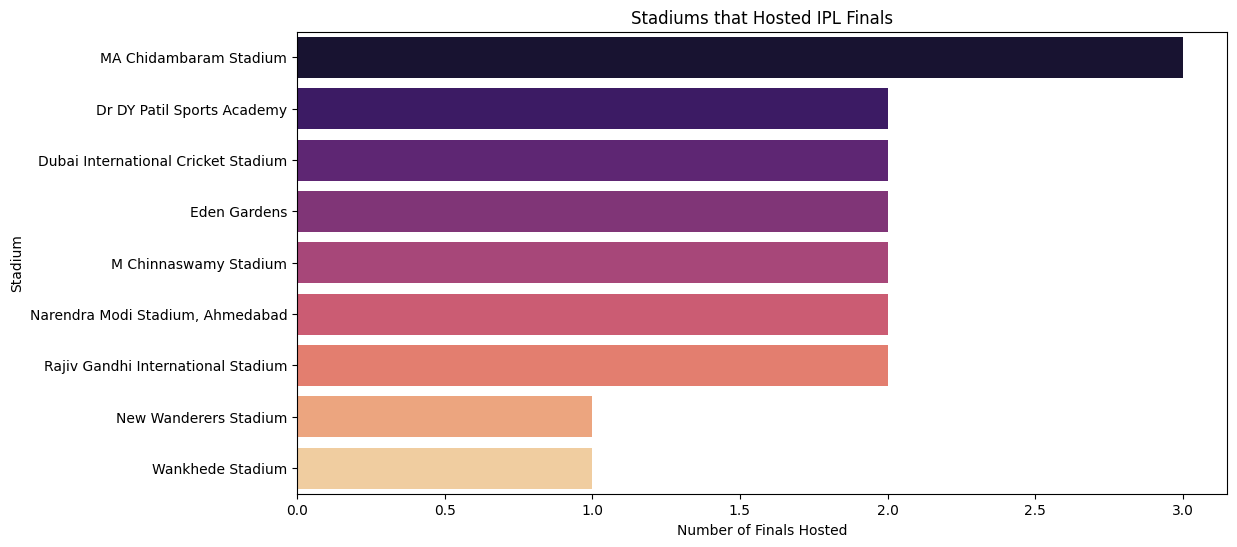

In [225]:
# Filter finals matches (assuming there's a column 'match_type')
finals_stadiums = matches[matches['match_type'] == 'Final'].value_counts('venue').reset_index()
finals_stadiums.columns = ['Stadium', 'Finals Hosted']

# Visualization - Bar Chart for Clear Count Representation
plt.figure(figsize=(12, 6))
sns.barplot(
    y=finals_stadiums['Stadium'],
    x=finals_stadiums['Finals Hosted'],
    hue=finals_stadiums['Stadium'],
    palette='magma'
)
plt.xlabel('Number of Finals Hosted')
plt.ylabel('Stadium')
plt.title('Stadiums that Hosted IPL Finals')
plt.show()


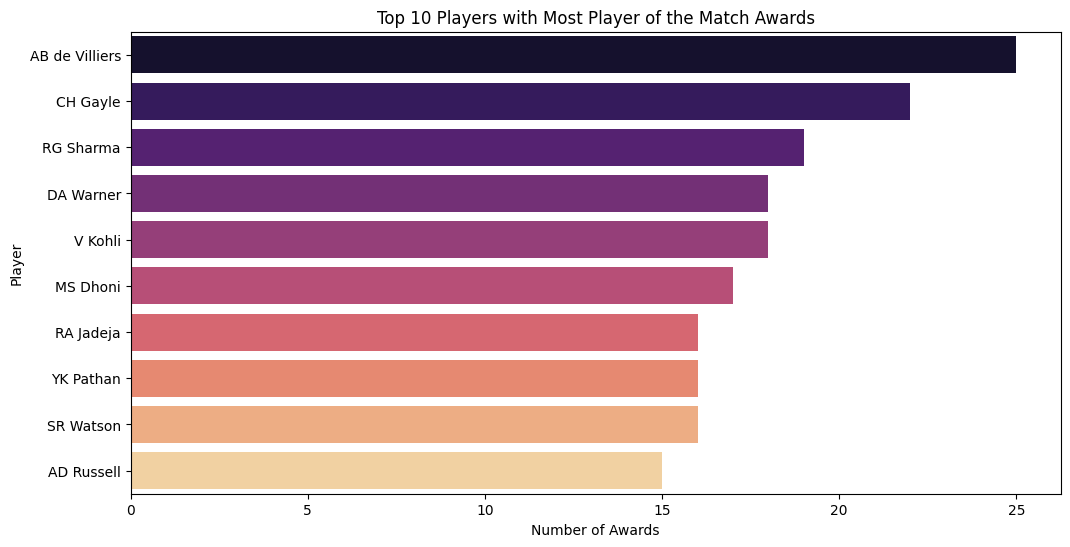

In [226]:
# Most Successful Players (Player of the Match Awards)
# Count Player of the Match awards
player_awards = matches.value_counts('player_of_match').reset_index()
player_awards.columns = ['Player', 'Awards']

# Select Top 5 players
top_5_players = player_awards.head(10)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Awards',
    y='Player',
    data=top_5_players,
    hue='Player',
    dodge=False,
    palette='magma',
    legend=False
)
plt.xlabel('Number of Awards')
plt.ylabel('Player')
plt.title('Top 10 Players with Most Player of the Match Awards')
plt.show()


In [227]:
# @title Matches Played and Winning Percentages
# Count matches played per team
matches_played = pd.concat([matches['team1'], matches['team2']]).value_counts().reset_index()
matches_played.columns = ['Team', 'Matches Played']

# Count matches won per team
matches_won = matches['winner'].value_counts().reset_index()
matches_won.columns = ['Team', 'Matches Won']

# Merge the data
team_stats = matches_played.merge(matches_won, on='Team', how='left').fillna(0)
team_stats['Winning Percentage'] = (team_stats['Matches Won'] / team_stats['Matches Played']) * 100

# Plot
fig = px.bar(team_stats, x='Team', y=['Matches Played', 'Matches Won'],
             title='Matches Played and Winning Percentage',
             labels={'value': 'Count', 'variable': 'Statistic'},
             color_discrete_sequence=['#FF7F50', '#008080'])  # Coral & Teal
fig.show()

In [228]:
# Batting Run Rate Calculation
batting_stats = deliveries.groupby('batting_team').agg(
    total_runs=('total_runs', 'sum'),
    valid_balls=('ball', 'count')  # Assuming all balls are valid
).reset_index()

batting_stats['run_rate'] = batting_stats['total_runs'] / (batting_stats['valid_balls'] / 6)
batting_stats

,batting_team,total_runs,valid_balls,run_rate
0,Chennai Super Kings,38629,28651,8.089561
1,Deccan Chargers,11463,9034,7.613239
2,Delhi Capitals,14900,10946,8.167367
3,Delhi Daredevils,24296,18786,7.759821
4,Gujarat Lions,4862,3566,8.180595
5,Gujarat Titans,7757,5494,8.471423
6,Kings XI Punjab,30064,22646,7.965380
7,Kochi Tuskers Kerala,1901,1582,7.209861
8,Kolkata Knight Riders,39331,29514,7.995731
9,Lucknow Super Giants,7510,5400,8.344444


In [229]:
# Bowling Economy Rate Calculation
bowling_stats = deliveries.groupby('bowling_team').agg(
    runs_conceded=('total_runs', 'sum'),
    valid_balls_bowled=('ball', 'count')
).reset_index()

bowling_stats['economy_rate'] = bowling_stats['runs_conceded'] / (bowling_stats['valid_balls_bowled'] / 6)
bowling_stats

,bowling_team,runs_conceded,valid_balls_bowled,economy_rate
0,Chennai Super Kings,37207,28576,7.812220
1,Deccan Chargers,11618,9039,7.711915
2,Delhi Capitals,15395,11216,8.235556
3,Delhi Daredevils,24730,18725,7.924166
4,Gujarat Lions,5090,3545,8.614951
5,Gujarat Titans,7475,5301,8.460668
6,Kings XI Punjab,30461,22483,8.129075
7,Kochi Tuskers Kerala,1986,1614,7.382900
8,Kolkata Knight Riders,39086,29663,7.906011
9,Lucknow Super Giants,7415,5226,8.513203


In [230]:
# Merging both batting and bowling stats
team_performance = batting_stats.merge(bowling_stats, left_on='batting_team', right_on='bowling_team')
team_performance = team_performance[['batting_team', 'run_rate', 'economy_rate']]

# @title Batting Run Rate vs Bowling Economy Rate
fig = px.bar(team_performance, x='batting_team', y=['run_rate', 'economy_rate'],
             title='Batting Run Rate vs Bowling Economy Rate',
             labels={'value': 'Rate', 'variable': 'Type'},
             color_discrete_sequence=['#FF7F50', '#008080'])  # Coral & Teal colors
fig.show()

# Scatter Plot - Run Rate vs Economy Rate (Per Match)
matches['Run Rate'] = matches['target_runs'] / matches['target_overs']
matches['Economy Rate'] = matches['result_margin'] / matches['target_overs']

fig = px.scatter(matches, x='Run Rate', y='Economy Rate', color='season',
                 title='Run Rate vs Economy Rate (Per Match)',
                 labels={'Run Rate': 'Run Rate (Batting)', 'Economy Rate': 'Economy Rate (Bowling)'},
                 color_discrete_sequence=px.colors.sequential.Cividis)
fig.show()

In [231]:
# @title highest and lowest scores of team

def get_batting_first(row):
    if row['toss_decision'] == 'bat':
        return row['toss_winner']
    else:
        if row['toss_winner'] == row['team1']:
            return row['team2']
        else:
            return row['team1']

matches['batting_first'] = matches.apply(get_batting_first, axis=1)

matches.rename(columns={'target_runs': 'first_innings_runs'}, inplace=True)
matches[['team1','team2','toss_winner','toss_decision','batting_first','first_innings_runs']].head()


,team1,team2,toss_winner,toss_decision,batting_first,first_innings_runs
0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,223.0
1,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,241.0
2,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Rajasthan Royals,130.0
3,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Mumbai Indians,166.0
4,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Deccan Chargers,111.0


In [232]:
# Get highest and lowest scores per team
score_stats = matches.groupby('batting_first')['first_innings_runs'].agg(['max', 'min']).reset_index()
score_stats.rename(columns={'batting_first': 'Team', 'max': 'Highest Score', 'min': 'Lowest Score'}, inplace=True)

# Plot
fig = px.bar(score_stats, x='Team', y=['Highest Score', 'Lowest Score'],
             title='Highest & Lowest Scores per Team',
             labels={'value': 'Runs', 'variable': 'Score Type'},
             barmode='group',
             color_discrete_sequence=['#FF7F50', '#90EE90'])  # Coral & Soft Green

fig.update_layout(xaxis_tickangle=-45)  # Rotate team names for better visibility
fig.show()

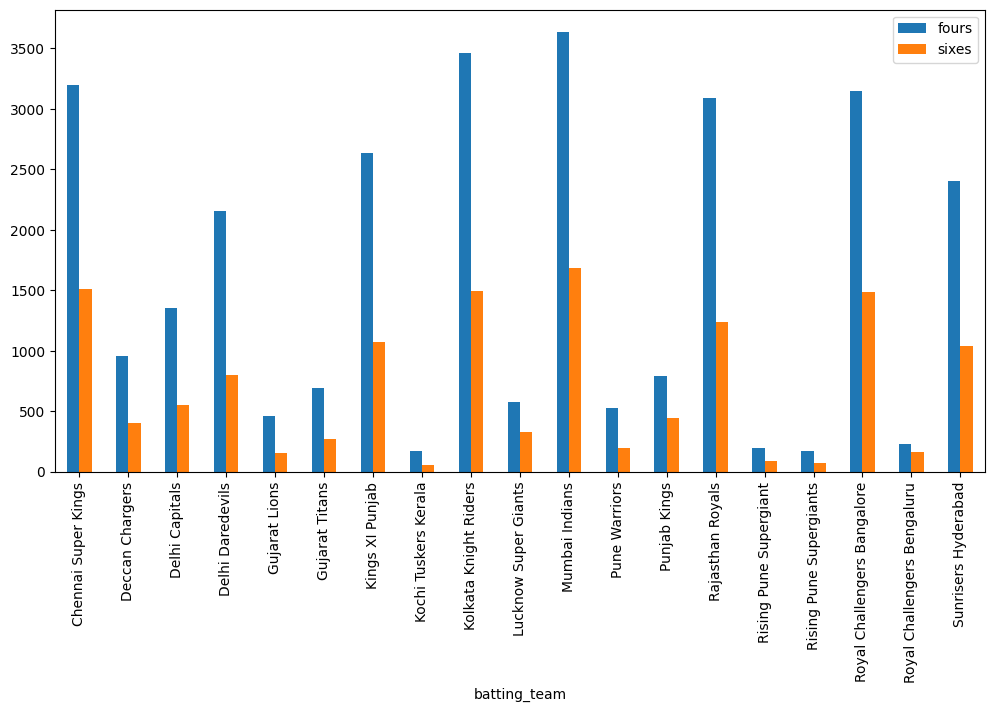

In [233]:
# @title Count the number of 4s and 6s for each team
boundaries_by_team = deliveries.groupby("batting_team").agg(
    fours=("batsman_runs", lambda x: (x == 4).sum()),
    sixes=("batsman_runs", lambda x: (x == 6).sum())
).reset_index()

# Set the index to 'team' and plot 'fours' and 'sixes' as grouped bars
boundaries_by_team.set_index("batting_team")[["fours", "sixes"]].plot(kind="bar", figsize=(12,6))

fig.update_layout(xaxis_title="Team",
                  yaxis_title="Count",
                  xaxis_tickangle=-45)  # Rotate labels for better readability

fig.show()

In [234]:
# @title Average Powerplay and Death Overs Score
# Filter Powerplay (1-6 overs) and Death Overs (16-20 overs)
powerplay_deliveries = deliveries[(deliveries['over'] >= 1) & (deliveries['over'] <= 6)]
death_deliveries = deliveries[(deliveries['over'] >= 16) & (deliveries['over'] <= 20)]

# Aggregate runs scored in these overs
pp_runs = powerplay_deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
death_runs = death_deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

# Rename columns
pp_runs.rename(columns={'total_runs': 'Powerplay Runs'}, inplace=True)
death_runs.rename(columns={'total_runs': 'Death Overs Runs'}, inplace=True)

# Calculate average powerplay and death overs score per team
pp_team_avg = pp_runs.groupby('batting_team')['Powerplay Runs'].mean().reset_index()
death_team_avg = death_runs.groupby('batting_team')['Death Overs Runs'].mean().reset_index()

# Merge both datasets
team_scores = pp_team_avg.merge(death_team_avg, on='batting_team')
team_scores = team_scores.sort_values(by='Powerplay Runs', ascending=False)

In [235]:
team_scores

,batting_team,Powerplay Runs,Death Overs Runs
17,Royal Challengers Bengaluru,57.933333,47.000000
4,Gujarat Lions,53.633333,32.892857
2,Delhi Capitals,51.714286,35.292135
12,Punjab Kings,51.517857,38.622642
18,Sunrisers Hyderabad,49.708791,36.261628
5,Gujarat Titans,49.244444,41.431818
14,Rising Pune Supergiant,49.125000,37.000000
9,Lucknow Super Giants,48.636364,40.904762
0,Chennai Super Kings,48.012658,39.741228
15,Rising Pune Supergiants,48.000000,40.272727


In [236]:
# Bar Plot for Powerplay & Death Overs Average Score
fig = px.bar(team_scores, x='batting_team', y=['Powerplay Runs', 'Death Overs Runs'],
             title='Average Powerplay and Death Overs Score',
             labels={'value': 'Average Score', 'variable': 'Phase'},
             color_discrete_sequence=['#008080', '#FF7F50'])  # Teal & Coral colors
fig.show()

In [237]:
# @title Total 4s and 6s by a team
boundaries = deliveries[deliveries['batsman_runs'].isin([4, 6])]

#group batsmen with team
boundary_counts = boundaries.groupby(['batting_team', 'batsman_runs']).size().unstack(fill_value=0).reset_index()
boundary_counts.columns = ['team', 'fours', 'sixes']

boundary_counts['total_boundaries'] = boundary_counts['fours'] + boundary_counts['sixes']

boundaries_by_team = boundary_counts.sort_values(by='total_boundaries', ascending=False)

boundaries_by_team

,team,fours,sixes,total_boundaries
10,Mumbai Indians,3637,1685,5322
8,Kolkata Knight Riders,3461,1495,4956
0,Chennai Super Kings,3196,1509,4705
16,Royal Challengers Bangalore,3149,1488,4637
13,Rajasthan Royals,3091,1237,4328
6,Kings XI Punjab,2631,1075,3706
18,Sunrisers Hyderabad,2405,1042,3447
3,Delhi Daredevils,2156,801,2957
2,Delhi Capitals,1352,550,1902
1,Deccan Chargers,957,400,1357


In [238]:
# @title Total 4s and 6s by a team
boundaries = deliveries[deliveries['batsman_runs'].isin([4, 6])]

#group batsmen with team
boundary_counts = boundaries.groupby(['batting_team', 'batsman_runs']).size().unstack(fill_value=0).reset_index()
boundary_counts.columns = ['team', 'fours', 'sixes']

boundary_counts['total_boundaries'] = boundary_counts['fours'] + boundary_counts['sixes']

boundaries_by_team = boundary_counts.sort_values(by='total_boundaries', ascending=False)

boundaries_by_team

,team,fours,sixes,total_boundaries
10,Mumbai Indians,3637,1685,5322
8,Kolkata Knight Riders,3461,1495,4956
0,Chennai Super Kings,3196,1509,4705
16,Royal Challengers Bangalore,3149,1488,4637
13,Rajasthan Royals,3091,1237,4328
6,Kings XI Punjab,2631,1075,3706
18,Sunrisers Hyderabad,2405,1042,3447
3,Delhi Daredevils,2156,801,2957
2,Delhi Capitals,1352,550,1902
1,Deccan Chargers,957,400,1357


In [239]:
# Bar Plot for Total 4s and 6s
fig = px.bar(four_six_data, x='Team', y=['Fours', 'Sixes'],
             title='Total 4s and 6s per Team',
             labels={'value': 'Count', 'variable': 'Shots'},
             color_discrete_sequence=['#008080', '#FF7F50'])
fig.show()

In [240]:
# @title Powerplay analysis of team
team_name = "Mumbai Indians"

pp_team_deliveries = deliveries[(deliveries['over'] >= 1) & (deliveries['over'] <= 6) &
                                (deliveries['batting_team'] == team_name)].copy()

def categorize(row):
    if row['is_wicket'] == 1:
        return 'Wicket'
    elif row['batsman_runs'] == 0 and row['extra_runs'] == 0:
        return 'Dot'
    elif row['batsman_runs'] == 4:
        return 'Four'
    elif row['batsman_runs'] == 6:
        return 'Six'
    elif row['batsman_runs'] in [1, 2, 3]:
        return 'Runs'
    else:
        return 'Other'

pp_team_deliveries['category'] = pp_team_deliveries.apply(categorize, axis=1)

# Count the number of deliveries in each category
category_counts = pp_team_deliveries['category'].value_counts()

# Calculate the percentage of each category relative to total deliveries
total_deliveries = pp_team_deliveries.shape[0]
category_percentage = (category_counts / total_deliveries) * 100

print("Delivery Outcome Percentages in Powerplay for", team_name)
category_percentage


Delivery Outcome Percentages in Powerplay for Mumbai Indians


,count
category,
Dot,39.373785
Runs,33.326512
Four,13.997749
Other,5.668679
Six,3.980354
Wicket,3.652921


In [241]:
# Pie Chart for Powerplay Analysis
fig = px.pie(names=category_percentage.index, values=category_percentage.values,
             title=f'Powerplay Analysis of {team_name}',
             color_discrete_sequence=['#008080', '#FF7F50', '#90EE90', '#FE6407', '#D3D3D3'])  # Teal, Coral, Soft Green, Orange, Light Gray

fig.update_traces(textinfo='percent+label')
fig.show()


## Venue Analysis

In [242]:
#deliveries by venue
deliveries_with_venue = deliveries.merge(matches[['id', 'venue']], left_on='match_id', right_on='id', how='left')
venue_runs = deliveries_with_venue.groupby('venue')['total_runs'].sum().reset_index().sort_values(by='total_runs', ascending=False)

venue_runs_sorted = venue_runs.sort_values(by='total_runs', ascending=False)

venue_runs_sorted

,venue,total_runs
42,Wankhede Stadium,38994
18,M Chinnaswamy Stadium,30712
11,Eden Gardens,29743
19,MA Chidambaram Stadium,26706
30,Rajiv Gandhi International Stadium,19519
12,Feroz Shah Kotla,18421
34,Sawai Mansingh Stadium,17685
10,Dubai International Cricket Stadium,14450
8,Dr DY Patil Sports Academy,11383
21,Maharashtra Cricket Association Stadium,11115


In [243]:
#Total Runs Scored at Each Venue
import plotly.express as px

fig = px.bar(venue_runs_sorted, x='venue', y='total_runs',
             title='Total Runs Scored at Each Venue',
             labels={'total_runs': 'Total Runs', 'venue': 'Venue'},
             color_discrete_sequence=['#008080'])  # Teal

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [244]:
# @title  4s and 6s in a venue
fours = deliveries_with_venue[deliveries_with_venue['batsman_runs'] == 4].groupby('venue').size().reset_index(name='fours')
sixes = deliveries_with_venue[deliveries_with_venue['batsman_runs'] == 6].groupby('venue').size().reset_index(name='sixes')
boundaries = pd.merge(fours, sixes, on='venue', how='outer').fillna(0)

boundaries['total_boundaries'] = boundaries['fours'] + boundaries['sixes']

boundaries_sorted = boundaries.sort_values(by='total_boundaries', ascending=False)

boundaries_sorted

,venue,fours,sixes,total_boundaries
42,Wankhede Stadium,3449,1611,5060
18,M Chinnaswamy Stadium,2569,1402,3971
11,Eden Gardens,2699,1183,3882
19,MA Chidambaram Stadium,2164,924,3088
30,Rajiv Gandhi International Stadium,1662,660,2322
12,Feroz Shah Kotla,1660,636,2296
34,Sawai Mansingh Stadium,1634,504,2138
10,Dubai International Cricket Stadium,1189,495,1684
0,Arun Jaitley Stadium,898,497,1395
8,Dr DY Patil Sports Academy,912,458,1370


In [245]:
fig = px.bar(boundaries_sorted, x='venue', y=['fours', 'sixes'],
             title='Total 4s and 6s at Each Venue',
             labels={'value': 'Count', 'variable': 'Shots', 'venue': 'Venue'},
             color_discrete_sequence=['#FE6407', '#90EE90'])  # Orange & Soft Green

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [246]:
#Total Wickets at Each Venue
wkts = deliveries_with_venue[deliveries_with_venue['is_wicket'] == 1].groupby('venue').size().reset_index(name='wickets').sort_values(by='wickets', ascending=False)
wkts

,venue,wickets
42,Wankhede Stadium,1422
18,M Chinnaswamy Stadium,1101
11,Eden Gardens,1071
19,MA Chidambaram Stadium,1023
30,Rajiv Gandhi International Stadium,755
12,Feroz Shah Kotla,697
34,Sawai Mansingh Stadium,623
10,Dubai International Cricket Stadium,545
8,Dr DY Patil Sports Academy,470
21,Maharashtra Cricket Association Stadium,434


In [247]:
fig = px.bar(wkts, x='venue', y='wickets',
             title='Total Wickets at Each Venue',
             labels={'wickets': 'Wickets', 'venue': 'Venue'},
             color_discrete_sequence=['#FF7F50'])  # Coral

fig.update_layout(xaxis_tickangle=-45)
fig.show()


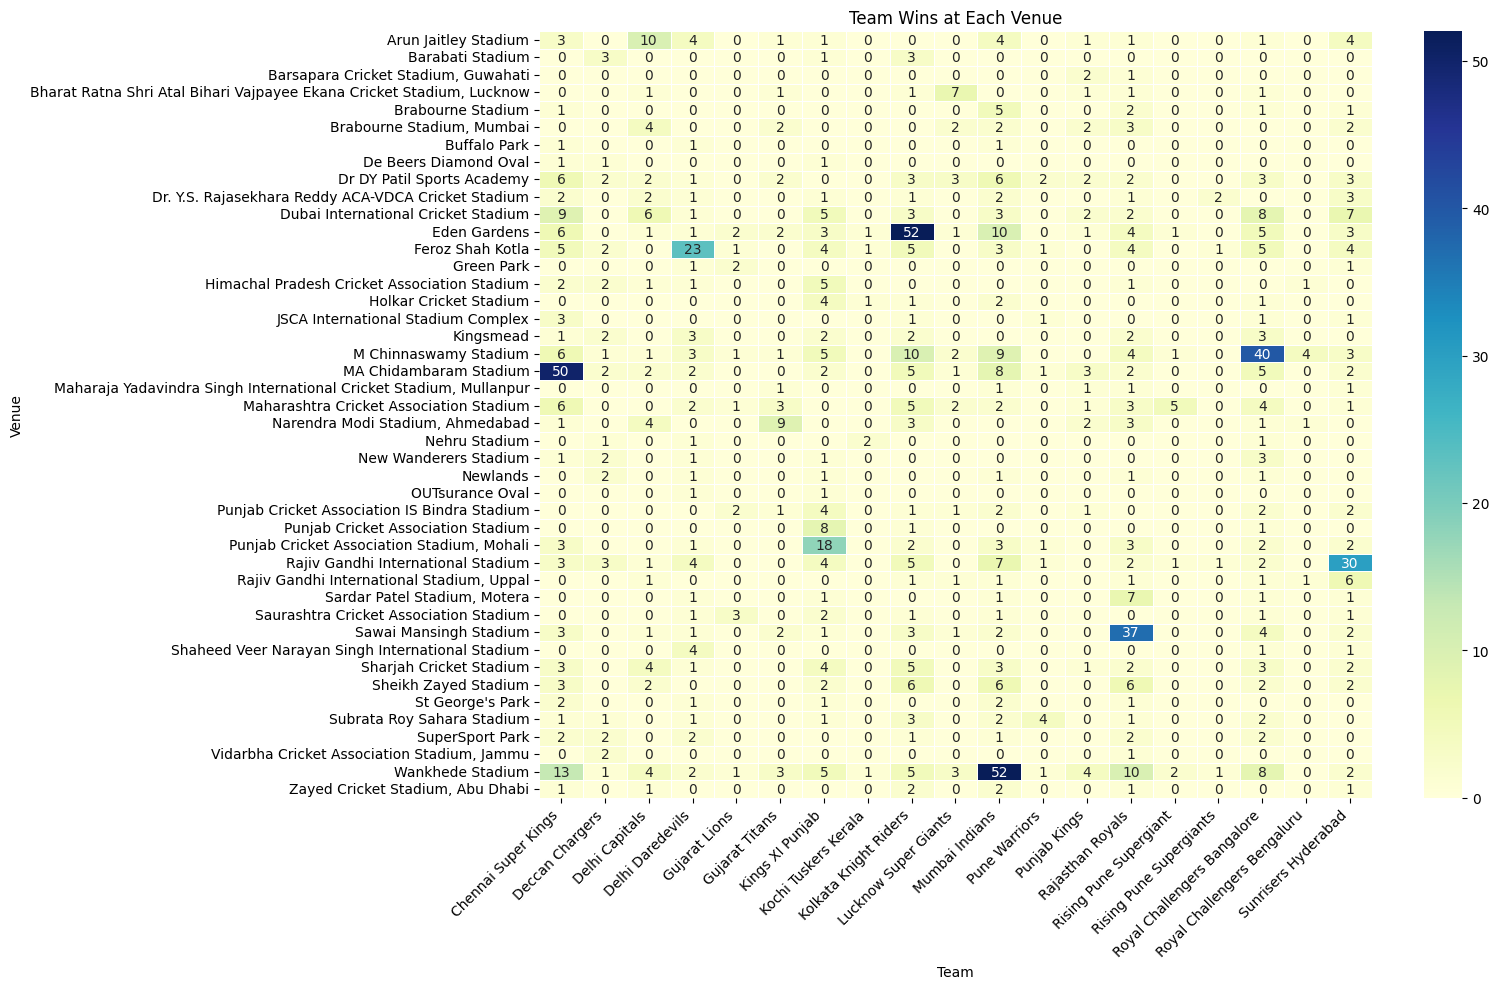

In [248]:
# @title Team with most wins at each venue

valid_matches = matches[matches['winner'] != "No Result"]

venue_team_wins = valid_matches.groupby(['venue', 'winner']).size().reset_index(name='wins')
venue_wins_pivot = venue_team_wins.pivot(index='venue', columns='winner', values='wins').fillna(0)

plt.figure(figsize=(16,10))
sns.heatmap(
    venue_wins_pivot,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",  # Yellow-Green-Blue theme
    annot_kws={'fontsize':10, 'linespacing':2},
    linewidths=0.5,
    linecolor='white'
)

plt.title("Team Wins at Each Venue")
plt.xlabel("Team")
plt.ylabel("Venue")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Player Performance:

In [249]:
# @title Player runs analysis Top 20 Runs scorer of all time

player_runs = deliveries.groupby('batter')['batsman_runs'].sum().reset_index()
player_runs.rename(columns={'batter': 'player', 'batsman_runs': 'total_runs'}, inplace=True)

top_run_scorers = player_runs.sort_values('total_runs', ascending=False).head(20);

top_run_scorers


,player,total_runs
631,V Kohli,8014
512,S Dhawan,6769
477,RG Sharma,6630
147,DA Warner,6567
546,SK Raina,5536
374,MS Dhoni,5243
30,AB de Villiers,5181
124,CH Gayle,4997
501,RV Uthappa,4954
282,KD Karthik,4843


In [250]:
fig = px.bar(top_run_scorers, x='player', y='total_runs',
             title='Top 20 Run-Scorers (All-Time)',
             labels={'total_runs': 'Total Runs', 'player': 'Player'},
             color='total_runs',
             color_continuous_scale='viridis')

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [251]:
# @title Batting Average vs Batting Strike Rate for the top 20 run-scorers
#  Compute total runs, balls faced, and dismissals per batter
batting_stats = deliveries.groupby("batter").agg(
    total_runs=("batsman_runs", "sum"),
    balls_faced=("ball", "count"),
    dismissals=("is_wicket", "sum")
).reset_index()

# Calculate Batting Average & Strike Rate
batting_stats["batting_avg"] = batting_stats["total_runs"] / batting_stats["dismissals"]
batting_stats["strike_rate"] = (batting_stats["total_runs"] / batting_stats["balls_faced"]) * 100

# Handling cases where dismissals = 0 (to avoid division by zero)
batting_stats["batting_avg"].fillna(0, inplace=True)

# Get Top 20 Run-Scorers
top_scorers = batting_stats.sort_values("total_runs", ascending=False).head(20)

# Plot Batting Average vs Strike Rate for Top 20 Run-Scorers
fig = px.scatter(top_scorers,
                 x="batting_avg",
                 y="strike_rate",
                 size="total_runs",
                 color="batter",
                 text="batter",
                 title="Batting Average vs Strike Rate (Top 20 Run-Scorers)",
                 labels={"batting_avg": "Batting Average", "strike_rate": "Strike Rate"},
                 hover_data=["total_runs", "balls_faced"])

fig.update_traces(textposition="top center")
fig.show()

In [252]:
# @title Highest Average and Strike Rate for players with >50 matches
# Compute total runs, balls faced, dismissals, and matches played per batter
batting_stats = deliveries.groupby("batter").agg(
    total_runs=("batsman_runs", "sum"),
    balls_faced=("ball", "count"),
    dismissals=("is_wicket", "sum"),
    matches_played=("match_id", "nunique")  # Count unique matches
).reset_index()

# Calculate Batting Average & Strike Rate
batting_stats["batting_avg"] = batting_stats["total_runs"] / batting_stats["dismissals"]
batting_stats["strike_rate"] = (batting_stats["total_runs"] / batting_stats["balls_faced"]) * 100

# Handling cases where dismissals = 0 (to avoid division by zero)
batting_stats["batting_avg"].fillna(0, inplace=True)

# Filter Players with >50 Matches
experienced_players = batting_stats[batting_stats["matches_played"] > 50]

# Find Highest Batting Average & Strike Rate for Players with >50 Matches
highest_avg_player = experienced_players.loc[experienced_players["batting_avg"].idxmax()]
highest_sr_player = experienced_players.loc[experienced_players["strike_rate"].idxmax()]

print("Player with Highest Batting Average (>50 matches):", highest_avg_player["batter"], highest_avg_player["batting_avg"])
print("Player with Highest Strike Rate (>50 matches):", highest_sr_player["batter"], highest_sr_player["strike_rate"])

Player with Highest Batting Average (>50 matches): KL Rahul 44.235849056603776
Player with Highest Strike Rate (>50 matches): AD Russell 164.22442244224422


In [253]:
# @title Bowlers with most wickets
valid_dismissals = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]

bowler_wickets = deliveries[
    (deliveries['is_wicket'] == 1) &
    (deliveries['dismissal_kind'].isin(valid_dismissals))
].groupby('bowler').size().reset_index(name='wickets')

top_wicket_takers = bowler_wickets.sort_values('wickets', ascending=False).head(10)

top_wicket_takers


,bowler,wickets
445,YS Chahal,205
297,PP Chawla,192
102,DJ Bravo,183
61,B Kumar,181
304,R Ashwin,180
379,SP Narine,180
7,A Mishra,174
372,SL Malinga,170
168,JJ Bumrah,168
319,RA Jadeja,160


In [254]:
fig = px.bar(top_wicket_takers, x='bowler', y='wickets',
             title='Top 10 Wicket-Takers (All-Time)',
             labels={'wickets': 'Total Wickets', 'bowler': 'Bowler'},
             color='wickets',
             color_continuous_scale='magma')

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [255]:
# @title Bowlers with most dot balls
# @title bowlers with most wickets

bowler_dots = deliveries[
    (deliveries['total_runs'] == 0)
].groupby('bowler').size().reset_index(name='dotballs')

top_bowlers_with_dot_balls = bowler_dots.sort_values('dotballs', ascending=False).head(20)

top_bowlers_with_dot_balls


,bowler,dotballs
70,B Kumar,1632
436,SP Narine,1569
348,R Ashwin,1552
341,PP Chawla,1325
159,Harbhajan Singh,1263
188,JJ Bumrah,1228
366,RA Jadeja,1216
511,YS Chahal,1194
482,UT Yadav,1186
8,A Mishra,1185


In [256]:
# @title top highest individual scores
# Top Bowlers with Most Dot Balls
fig = px.bar(top_bowlers_with_dot_balls, x='bowler', y='dotballs',
             title='Top Bowlers with Most Dot Balls',
             labels={'dotballs': 'Total Dot Balls', 'bowler': 'Bowler'},
             color='dotballs',
             color_continuous_scale='magma')

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [257]:
# @title Man of the Match Count Analysis
# Count the number of times each player has won 'Man of the Match'
mom_counts = matches["player_of_match"].value_counts().reset_index()
mom_counts.columns = ["player", "count"]

# Get top 10 players with most Man of the Match awards
top_mom_players = mom_counts.head(10)

# Plot
fig = px.bar(top_mom_players, x="player", y="count",
             title="Top 10 Players with Most Man of the Match Awards",
             labels={"count": "Number of Awards", "player": "Player"},
             color="count",
             color_continuous_scale="inferno")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

## K-Means Clustering to plot Batting Average vs Bowling Economy Rate for number of clusters = 3

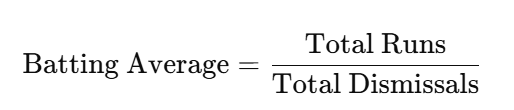



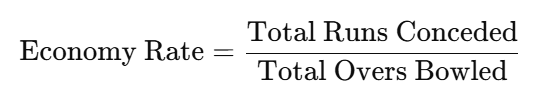

In [258]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Compute Batting Stats
batting_stats = deliveries.groupby("batter").agg(
    total_runs=("batsman_runs", "sum"),
    dismissals=("is_wicket", "sum")
).reset_index()

# Compute Batting Average, handle division by zero
batting_stats["batting_average"] = np.where(
    batting_stats["dismissals"] > 0,
    batting_stats["total_runs"] / batting_stats["dismissals"],
    0  # Assign zero if player never got out
)

# Compute Bowling Stats
bowling_stats = deliveries.groupby("bowler").agg(
    total_runs_conceded=("total_runs", "sum"),
    total_balls=("ball", "count")
).reset_index()

# Convert balls into overs (6 balls per over)
bowling_stats["overs"] = bowling_stats["total_balls"] / 6

# Compute Economy Rate, handle division by zero
bowling_stats["economy_rate"] = np.where(
    bowling_stats["overs"] > 0,
    bowling_stats["total_runs_conceded"] / bowling_stats["overs"],
    0  # Assign zero if player never bowled
)

# Merge Batting & Bowling Stats
player_stats = pd.merge(batting_stats, bowling_stats, left_on="batter", right_on="bowler", how="outer").fillna(0)

# Select relevant columns
player_stats = player_stats[["batter", "batting_average", "economy_rate"]]
player_stats.rename(columns={"batter": "player"}, inplace=True)

# Remove players who neither batted nor bowled
player_stats = player_stats[(player_stats["batting_average"] > 0) | (player_stats["economy_rate"] > 0)]

# Standardize features for K-Means
scaler = StandardScaler()
scaled_features = scaler.fit_transform(player_stats[["batting_average", "economy_rate"]])

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
player_stats["cluster"] = kmeans.fit_predict(scaled_features)

# Assign labels to clusters
cluster_labels = {0: "Batsman", 1: "Bowler", 2: "All-Rounder"}
player_stats["role"] = player_stats["cluster"].map(cluster_labels)

# Scatter Plot
fig = px.scatter(player_stats, x="batting_average", y="economy_rate",
                 color="role", hover_data=["player"],
                 title="K-Means Clustering: Batting Average vs Bowling Economy Rate",
                 labels={"batting_average": "Batting Average", "economy_rate": "Bowling Economy Rate"},
                 color_discrete_map={"Batsman": "blue", "Bowler": "red", "All-Rounder": "green"})

fig.show()


##  Top 10 Batsmen in each run category

In [259]:
pom_counts = matches['player_of_match'].value_counts().reset_index()
pom_counts.columns = ['player', 'awards']

top_pom = pom_counts.head(10)

fig = px.bar(top_pom, x='player', y='awards',
             title='Top 10 Player of the Match Awards',
             labels={'awards': 'Total Awards', 'player': 'Player'},
             color='awards',
             color_continuous_scale='inferno')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [260]:
# Get highest individual score by batter per match
highest_scores = deliveries.groupby(["match_id", "batter"]).agg(
    runs_scored=("batsman_runs", "sum")
).reset_index()

# Get top highest individual scores
top_individual_scores = highest_scores.sort_values("runs_scored", ascending=False).head(10)

# Plot
fig = px.bar(top_individual_scores, x="batter", y="runs_scored",
             title="Top 10 Highest Individual Scores in a Match",
             labels={"runs_scored": "Runs Scored", "batter": "Batter"},
             color="runs_scored",
             color_continuous_scale="reds")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [261]:
# @title Top 6s scorer

player_sixes = deliveries[deliveries['batsman_runs'] == 6].groupby('batter').size().reset_index(name='sixes')

top_six_hitters = player_sixes.sort_values('sixes', ascending=False).head(10)

fig = px.bar(top_six_hitters, x='batter', y='sixes',
             title='Top 10 Six Scorers',
             labels={'sixes': 'Total Sixes', 'batter': 'Player'},
             color='sixes',
             color_continuous_scale='Reds')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [262]:
# @title Top 4s scorer

player_fours = deliveries[deliveries['batsman_runs'] == 4].groupby('batter').size().reset_index(name='fours')

top_four_hitters = player_fours.sort_values('fours', ascending=False).head(10)

fig = px.bar(top_four_hitters, x='batter', y='fours',
             title='Top 10 Four Scorers',
             labels={'fours': 'Total Fours', 'batter': 'Player'},
             color='fours',
             color_continuous_scale='Reds')

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [263]:
player_twos = deliveries[deliveries['batsman_runs'] == 2].groupby('batter').size().reset_index(name='twos')

top_two_hitters = player_twos.sort_values('twos', ascending=False).head(10)  # Corrected variable

fig = px.bar(top_two_hitters, x='batter', y='twos',
             title='Top 10 2-Run Scorers',
             labels={'twos': 'Total 2s', 'batter': 'Player'},
             color='twos',
             color_continuous_scale='Reds')

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [264]:
# @title Top 1s scorer

player_ones = deliveries[deliveries['batsman_runs'] == 1].groupby('batter').size().reset_index(name='ones')

top_one_hitters = player_ones.sort_values('ones', ascending=False).head(10)

fig = px.bar(top_one_hitters, x='batter', y='ones',
             title='Top 10 1-Run Scorers',
             labels={'ones': 'Total 1s', 'batter': 'Player'},
             color='ones',
             color_continuous_scale='Reds')

fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [265]:
# @title Plot Batting Average vs Batting Strike Rate for the top 20 run-scorers

#batting avg = total runs / dismissals
#strike rate = total runs * 100 / balls faced


# Aggregate total runs and count balls faced for each batter
batter_stats = deliveries.groupby('batter').agg(
    total_runs=('batsman_runs', 'sum'),
    balls_faced=('ball', 'count')
).reset_index()

# Calculate dismissals
dismissals = deliveries[deliveries['player_dismissed'].notnull()] \
    .groupby('player_dismissed').size().reset_index(name='dismissals')
dismissals.rename(columns={'player_dismissed': 'batter'}, inplace=True)

# Merge dismissals with batter_stats
batter_stats = batter_stats.merge(dismissals, on='batter', how='left')
batter_stats['dismissals'] = batter_stats['dismissals'].fillna(0)

# Calculate batting average
batter_stats['batting_average'] = batter_stats.apply(
    lambda row: row['total_runs'] / row['dismissals'] if row['dismissals'] > 0 else np.nan,
    axis=1
)

# Calculate strike rate
batter_stats['strike_rate'] = (batter_stats['total_runs'] / batter_stats['balls_faced']) * 100

# Select top 20 run-scorers
top20 = batter_stats.sort_values('total_runs', ascending=False).head(20)

top20

,batter,total_runs,balls_faced,dismissals,batting_average,strike_rate
631,V Kohli,8014,6236,207.0,38.714976,128.511867
512,S Dhawan,6769,5483,193.0,35.072539,123.454313
477,RG Sharma,6630,5183,223.0,29.730942,127.918194
147,DA Warner,6567,4849,164.0,40.042683,135.429986
546,SK Raina,5536,4177,171.0,32.374269,132.535312
374,MS Dhoni,5243,3947,134.0,39.126866,132.835065
30,AB de Villiers,5181,3487,130.0,39.853846,148.580442
124,CH Gayle,4997,3516,126.0,39.658730,142.121729
501,RV Uthappa,4954,3927,180.0,27.522222,126.152279
282,KD Karthik,4843,3687,184.0,26.320652,131.353404


In [266]:
# Ensure dismissals are NaN where not applicable
batter_stats['dismissals'] = batter_stats['dismissals'].replace(0, np.nan)

# Select top 20 run-scorers
top20 = batter_stats.sort_values('total_runs', ascending=False).head(20)

# Scatter plot using Plotly
fig = px.scatter(top20, x='strike_rate', y='batting_average',
                 text='batter', size='total_runs', color='total_runs',
                 title="Batting Average vs Strike Rate (Top 20 Run-Scorers)",
                 labels={'strike_rate': 'Batting Strike Rate', 'batting_average': 'Batting Average'},
                 color_continuous_scale='Plasma')

# Improve layout
fig.update_traces(marker=dict(opacity=0.8, line=dict(width=1, color='black')),
                  textposition='top center')

fig.update_layout(xaxis=dict(title="Strike Rate", gridcolor="lightgray"),
                  yaxis=dict(title="Batting Average", gridcolor="lightgray"),
                  coloraxis_colorbar=dict(title="Total Runs"),
                  template="plotly_white")

fig.show()

In [267]:
# @title average runs per match per season
deliv_season = deliveries.merge(matches[['id', 'season']], left_on='match_id', right_on='id', how='left')

# Total Runs per Season
season_runs = deliv_season.groupby('season')['total_runs'].sum().reset_index()
fig_runs = px.bar(season_runs, x='season', y='total_runs', title='Total Runs Scored Each Season',
                  labels={'season': 'Season', 'total_runs': 'Total Runs'}, color='total_runs',
                  color_continuous_scale='viridis')
fig_runs.show()

# Average Runs per Match per Season
match_runs = deliv_season.groupby(['match_id', 'season'])['total_runs'].sum().reset_index()
avg_runs_per_season = match_runs.groupby('season')['total_runs'].mean().reset_index()
fig_avg_runs = px.line(avg_runs_per_season, x='season', y='total_runs', markers=True,
                       title='Average Runs per Match per Season',
                       labels={'season': 'Season', 'total_runs': 'Average Runs'})
fig_avg_runs.show()

In [268]:
# @title Matches with Target of 200+ Runs per Season
targets_200 = matches[(matches['first_innings_runs'].notnull()) & (matches['first_innings_runs'] >= 200)]
targets_per_season = targets_200.groupby('season').size().reset_index(name='200+_targets')
fig_200plus = px.bar(targets_per_season, x='season', y='200+_targets', title='Matches with 200+ Targets per Season',
                     labels={'season': 'Season', '200+_targets': 'Count'}, color='200+_targets',
                     color_continuous_scale='inferno')
fig_200plus.show()

In [269]:
# @title Runs of Orange Cap Holders per Season
season_batter_runs = deliv_season.groupby(['season', 'batter'])['batsman_runs'].sum().reset_index()
orange_cap = season_batter_runs.loc[season_batter_runs.groupby('season')['batsman_runs'].idxmax()]
fig_orange_cap = px.bar(orange_cap, x='season', y='batsman_runs', title='Orange Cap Holder Runs per Season',
                         labels={'season': 'Season', 'batsman_runs': 'Total Runs'}, color='batsman_runs',
                         color_continuous_scale='viridis', text='batter')
fig_orange_cap.show()

In [270]:
# @title Wickets of Purple Cap Holders per Season
valid_dismissals = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]
season_bowler_wkts = deliv_season[(deliv_season['is_wicket'] == 1) &
                                   (deliv_season['dismissal_kind'].isin(valid_dismissals))]
grouped_wickets = season_bowler_wkts.groupby(['season', 'bowler']).size().reset_index(name='wickets')
purple_cap = grouped_wickets.loc[grouped_wickets.groupby('season')['wickets'].idxmax()]
fig_purple_cap = px.line(purple_cap, x='season', y='wickets', markers=True,
                         title='Purple Cap Holder Wickets per Season',
                         labels={'season': 'Season', 'wickets': 'Total Wickets'}, text='bowler')
fig_purple_cap.show()


In [271]:
# @title Top 10 Batters per Season
batters_season = season_batter_runs.groupby('season').apply(lambda x: x.nlargest(10, 'batsman_runs')).reset_index(drop=True)
heatmap_data = batters_season.pivot(index='season', columns='batter', values='batsman_runs').fillna(0)
fig_batters = px.imshow(heatmap_data, labels={'x': 'Batter', 'y': 'Season', 'color': 'Runs'},
                        title='Top 10 Batters per Season')
fig_batters.show()

In [272]:
# @title Top 10 Bowlers per Season
top10_bowlers = grouped_wickets.groupby('season').apply(lambda x: x.nlargest(10, 'wickets')).reset_index(drop=True)
heatmap_bowlers = top10_bowlers.pivot(index='season', columns='bowler', values='wickets').fillna(0)
fig_bowlers = px.imshow(heatmap_bowlers, labels={'x': 'Bowler', 'y': 'Season', 'color': 'Wickets'},
                        title='Top 10 Bowlers per Season')
fig_bowlers.show()

## Feature Extraction & Winner Prediction Model

In [273]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

**1. Data Loading and Preparation**
- Function: load_and_prepare_data(matches_file, deliveries_file)
- Purpose: Loads raw CSV data files containing match and delivery information

  ***Input***:
  - matches_file: Path to matches CSV file
  - deliveries_file: Path to deliveries CSV file

  ***Output***:
  - matches: DataFrame with match-level data
  - deliveries: DataFrame with ball-by-ball data

  ***Process***:
  - Reads CSV files using pandas


In [274]:
# Load the data
def load_and_prepare_data(matches_file, deliveries_file):
    print("Loading match data...")
    # Load matches data
    matches = pd.read_csv(matches_file)

    # Load deliveries data
    deliveries = pd.read_csv(deliveries_file)

    print(f"Loaded {len(matches)} matches and {len(deliveries)} ball-by-ball records")

    return matches, deliveries

**2. Data Cleaning**

- Function: clean_matches_data(matches)
- Purpose: Preprocesses the matches dataset

  ***Input***:
  - matches: Raw matches DataFrame

  ***Output***:
  - matches: Cleaned and encoded matches DataFrame

  ***Process***:
  - Converts dates to datetime format
  - Extracts year from dates
  - Handles missing values with defaults:
    - player_of_match → "Unknown"
    - result_margin → 0
    - city → "Unknown"

Encodes categorical variables using LabelEncoder for:
team1, team2, toss_winner, winner, city, venue

In [275]:
def clean_matches_data(matches):
    print("Cleaning matches data...")
    # Convert date to datetime
    matches['date'] = pd.to_datetime(matches['date'], errors='coerce')

    # Extract year from date
    matches['year'] = matches['date'].dt.year

    # Handle missing values
    matches.fillna({
        'player_of_match': 'Unknown',
        'result_margin': 0,
        'city': 'Unknown'
    }, inplace=True)

    # Encode categorical variables
    le = LabelEncoder()
    for col in ['team1', 'team2', 'toss_winner', 'winner', 'city', 'venue']:
        matches[col] = le.fit_transform(matches[col])

    return matches

**3. Team Performance Extraction**

- Function: extract_team_performance(matches, deliveries)
- Purpose: Calculates statistical metrics for each team

  ***Input***:
  - matches: Cleaned matches DataFrame
  - deliveries: Deliveries DataFrame

  ***Output***:
  - team_stats: Dictionary with team performance metrics

  ***Metrics Calculated:***
  - Wins and matches played
  - Win rate
  - Toss win rate
  - Home advantage
  - Run rate (from deliveries)
  - Economy rate (from deliveries)
  - Wickets taken



In [276]:
def extract_team_performance(matches, deliveries):
    print("Extracting team performance metrics...")

    # Calculate team-wise statistics
    team_stats = {}

    # Get list of teams
    teams = pd.concat([matches['team1'], matches['team2']]).unique()

    for team in teams:
        # Matches won
        wins = len(matches[matches['winner'] == team])

        # Matches played
        played = len(matches[(matches['team1'] == team) | (matches['team2'] == team)])

        # Win rate
        win_rate = wins / played if played > 0 else 0

        # Toss win rate
        toss_wins = len(matches[matches['toss_winner'] == team])
        toss_win_rate = toss_wins / played if played > 0 else 0

        # Home advantage
        home_matches = len(matches[matches['team1'] == team])
        home_wins = len(matches[(matches['team1'] == team) & (matches['winner'] == team)])
        home_advantage = home_wins / home_matches if home_matches > 0 else 0

        # Batting stats from deliveries
        if deliveries is not None:
            team_deliveries = deliveries[deliveries['batting_team'] == team]
            total_runs = team_deliveries['total_runs'].sum()
            total_balls = len(team_deliveries)
            run_rate = total_runs / (total_balls / 6) if total_balls > 0 else 0

            # Bowling stats
            team_bowling = deliveries[deliveries['bowling_team'] == team]
            wickets_taken = team_bowling['is_wicket'].sum()
            economy_rate = (team_bowling['total_runs'].sum() / (len(team_bowling) / 6)) if len(team_bowling) > 0 else 0
        else:
            run_rate = 0
            economy_rate = 0
            wickets_taken = 0

        # Store all stats
        team_stats[team] = {
            'wins': wins,
            'played': played,
            'win_rate': win_rate,
            'toss_win_rate': toss_win_rate,
            'home_advantage': home_advantage,
            'run_rate': run_rate,
            'economy_rate': economy_rate,
            'wickets_taken': wickets_taken
        }

    return team_stats

**4. Model Data Preparation**
- Function: prepare_model_data(matches, team_stats)
- Purpose: Creates feature matrix and target vector for model training

  ***Input***:
  - matches: Cleaned matches DataFrame
  - team_stats: Team performance statistics

  ***Output***:
  - X: Feature matrix (numpy array)
  - y: Target vector (numpy array)

  ***Features***:
  - Team 1 statistics
  - Team 2 statistics
  - Toss winner (binary)
  - Year

  ***Target***:
  - 1 if Team 1 wins, 0 if Team 2 wins



In [277]:
def prepare_model_data(matches, team_stats):
    print("Preparing model training data...")

    # Create feature datasets for each match
    X = []
    y = []

    for _, match in matches.iterrows():
        team1 = match['team1']
        team2 = match['team2']
        winner = match['winner']

        # Only use matches with a valid winner
        if pd.notna(winner):
            # Features for team1
            if team1 in team_stats:
                team1_features = list(team_stats[team1].values())
            else:
                team1_features = [0] * len(next(iter(team_stats.values())))

            # Features for team2
            if team2 in team_stats:
                team2_features = list(team_stats[team2].values())
            else:
                team2_features = [0] * len(next(iter(team_stats.values())))

            # Toss winner (1 if team1, 0 if team2)
            toss = 1 if match['toss_winner'] == team1 else 0

            # Combine features
            features = team1_features + team2_features + [toss, match['year']]
            X.append(features)

            # Target: 1 if team1 wins, 0 if team2 wins
            y.append(1 if winner == team1 else 0)

    return np.array(X), np.array(y)

**5. Model Training**
- Function: train_model(X, y)
- Purpose: Trains a Random Forest Classifier

  ***Input***:
  - X: Feature matrix
  - y: Target vector

  ***Output***:
  model: Trained RandomForestClassifier

  ***Process***:
  - Splits data into 80% training, 20% testing
  - Trains model with 100 estimators
  - Evaluates performance with:
    - Accuracy score
    - F1-score
    - Classification report



In [278]:
def train_model(X, y):
    print("Training prediction model...")

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a random forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute accuracy and F1-score
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Create a results table
    results_df = pd.DataFrame({
        'Dataset': ['Training', 'Testing'],
        'Accuracy': [train_accuracy, test_accuracy],
        'F1-score': [train_f1, test_f1]
    })

    print(results_df.to_string(index=False))

    # Print classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    return model


***6. Winner Prediction***
- Function: predict_ipl_winner(model, team_stats, current_teams, year)
- Purpose: Predicts IPL 2025 winner

  ***Input***:
  - model: Trained model
  - team_stats: Team performance statistics
  - current_teams: List of current IPL teams
  - year: Prediction year (default: 2025)

  ***Output***:
  - winner: Predicted winning team
  - runner_up: Predicted runner-up
  - sorted_results: All team rankings

  ***Process***:
  - Simulates round-robin matches
  - Uses model probabilities to assign fractional wins
  - Ranks teams based on total scores

In [279]:
def predict_ipl_winner(model, team_stats, current_teams, year=2025):
    print(f"Predicting IPL {year} winner...")

    # Get current teams in IPL
    teams = current_teams

    # Simulate all possible match combinations between teams
    results = {}
    for team in teams:
        results[team] = 0

    # Simulate round-robin matches
    for i, team1 in enumerate(teams):
        for team2 in teams[i+1:]:
            # Prepare features for prediction
            if team1 in team_stats:
                team1_features = list(team_stats[team1].values())
            else:
                team1_features = [0] * len(next(iter(team_stats.values())))

            if team2 in team_stats:
                team2_features = list(team_stats[team2].values())
            else:
                team2_features = [0] * len(next(iter(team_stats.values())))

            # Simulate both toss possibilities
            for toss in [0, 1]:
                features = team1_features + team2_features + [toss, year]

                # Predict
                prediction = model.predict_proba([features])[0]

                # Add fractional wins based on prediction probability
                if prediction[1] > 0.5:
                    results[team1] += prediction[1]
                else:
                    results[team2] += prediction[0]

    # Sort teams by results
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

    # Print results
    print("\nTeam Predictions for IPL 2025:")
    print("=============================")
    for i, (team, score) in enumerate(sorted_results):
        print(f"{i+1}. {team}: {score:.2f}")

    winner = sorted_results[0][0]
    runner_up = sorted_results[1][0]

    return winner, runner_up, sorted_results

**7. Main Execution**
- Function: main()
- Purpose: Orchestrates the entire prediction pipeline

***Process***:
- Defines current IPL teams
- Executes all steps in sequence
- Handles exceptions with fallback predictions
- Prints results and analysis notes



In [280]:
# Define current IPL teams (2025)
current_teams = [
    "Mumbai Indians",
    "Chennai Super Kings",
    "Royal Challengers Bangalore",
    "Kolkata Knight Riders",
    "Delhi Capitals",
    "Punjab Kings",
    "Rajasthan Royals",
    "Sunrisers Hyderabad",
    "Gujarat Titans",
    "Lucknow Super Giants"
]

In [281]:
try:
    # Try to load and process the data
    matches, deliveries = load_and_prepare_data("matches.csv", "deliveries.csv")

    # Clean the matches data
    matches = clean_matches_data(matches)

    # Extract team performance stats
    team_stats = extract_team_performance(matches, deliveries)

    # Prepare data for model training
    X, y = prepare_model_data(matches, team_stats)

    # Train prediction model
    model = train_model(X, y)

    # Predict winner
    winner, runner_up, all_results = predict_ipl_winner(model, team_stats, current_teams)

    print(f"\n🏆 Predicted IPL 2025 Winner: {winner}")
    print(f"🥈 Predicted Runner-up: {runner_up}")

    print("\nAnalysis Notes:")
    print("* This prediction is based on historical performance patterns")
    print("* Recent player transfers, injuries, and retirements are not accounted for")
    print("* Match conditions, pitch behavior, and weather factors can influence outcomes")

except Exception as e:
    print(f"Error occurred: {e}")

Loading match data...
Loaded 1095 matches and 260920 ball-by-ball records
Cleaning matches data...
Extracting team performance metrics...
Preparing model training data...
Training prediction model...
 Dataset  Accuracy  F1-score
Training  0.960046  0.960042
 Testing  0.534247  0.534014

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.48      0.60      0.54        98
           1       0.60      0.48      0.53       121

    accuracy                           0.53       219
   macro avg       0.54      0.54      0.53       219
weighted avg       0.55      0.53      0.53       219

Predicting IPL 2025 winner...

Team Predictions for IPL 2025:
1. Mumbai Indians: 12.24
2. Chennai Super Kings: 10.88
3. Royal Challengers Bangalore: 9.52
4. Kolkata Knight Riders: 8.16
5. Delhi Capitals: 6.80
6. Punjab Kings: 5.44
7. Rajasthan Royals: 4.08
8. Sunrisers Hyderabad: 2.72
9. Gujarat Titans: 1.36
10. Lucknow Super Giants: 0.00

🏆 Predict